# Dimensionality Reduction with Gaussian Processes

# Gaussian Process Summer School, Melbourne, Australia
### 25th-27th February 2015
### written by Max Zwiessele, Neil D. Lawrence


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pods
import GPy
import string

/Users/neil/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module pods was already imported from /Users/neil/sods/ods/pods/__init__.pyc, but /Users/neil/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


For this lab, we've created a dataset `digits.npy` containing all handwritten digits from $0 \cdots 9$ handwritten, provided by deCampos et al. [2009]. All digits were cropped and scaled down to an appropriate format.

We will only use some of the digits for the demonstrations in this lab class, but you can edit the code below to select different subsets of the digit data as you wish.

You can try to plot some sample using `plt.matshow`.

## Principal Component Analysis

Principal component analysis (PCA) finds a rotation of the observed outputs, such that the rotated principal component (PC) space maximizes the variance of the data observed, sorted from most to least important (most to least variable in the corresponding PC).

In order to apply PCA in an easy way, we have included a PCA module in pca.py. You can import the module by 
import <path.to.pca> (without the ending .py!). 
To run PCA on the digits we have to reshape (Hint: np.reshape ) digits . 

* What is the right shape $n \times d$ to use?

We will call the reshaped observed outputs $\mathbf{Y}$ in the following.

In [2]:
data = pods.datasets.decampos_digits(which_digits=[0,1,2,6,7,9])
Y = data['Y']
labels = data['lbls']
#Y = digits.reshape((digits.shape[0]*digits.shape[1],digits.shape[2]*digits.shape[3]))
Yn = data['Y']-data['Y'].mean()

Now let’s run PCA on the reshaped dataset $\mathbf{Y}$:

In [3]:
import pca
p = pca.PCA(Y) # create PCA class with digits dataset

The resulting plot will show the lower dimensional representation of the digits in 2 dimensions.

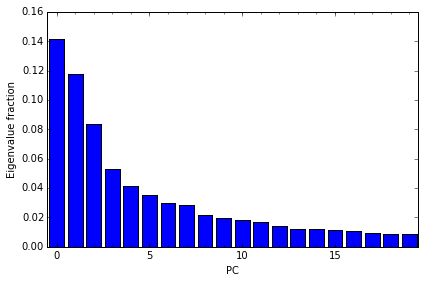

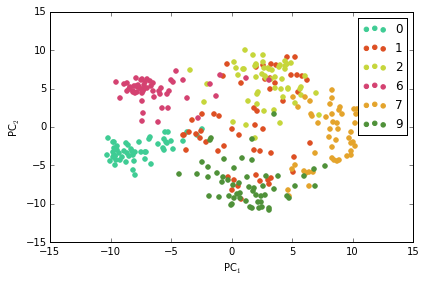

In [4]:
colors = ["#3FCC94", "#DD4F23", "#C6D63B", "#D44271", 
          "#E4A42C", "#4F9139", "#6DDA4C", "#85831F", 
          "#B36A29", "#CF4E4A"]
p.plot_fracs(20) # plot first 20 eigenvalue fractions
p.plot_2d(Y,labels=labels.flatten(), colors=colors)
plt.legend()

## Gaussian Process Latent Variable Model

The Gaussian Process Latent Variable Model (GP-LVM) embeds of PCA into a Gaussian process framework, where the latent inputs $\mathbf{X}$ are learnt as hyperparameters and the mapping variables $\mathbf{W}$ are integrated out. The advantage of this interpretation is it allows PCA to be generalized in a non linear way by replacing the resulting *linear* covariance witha  non linear covariance. But first, let's see how GPLVM is equivalent to PCA using an automatic relevance determination (ARD, see e.g. Bishop et al. [2006]) linear kernel:

In [5]:

def plot_model(m, which_dims, labels):
    fig = plt.figure(); ax = fig.add_subplot(111)
    X = m.X[:,which_dims]
    ulabs = []
    for lab in labels:
        if not lab in ulabs:
            ulabs.append(lab)
            pass
        pass
    for i, lab in enumerate(ulabs):
        ax.scatter(*X[labels==lab].T,marker='o',color=colors[i],label=lab)
        pass
    pass


In [6]:
input_dim = 4 # How many latent dimensions to use
kernel = GPy.kern.Linear(input_dim, ARD=True) # ARD kernel
#kernel += GPy.kern.white(input_dim) + GPy.kern.bias(input_dim)
model = GPy.models.GPLVM(Yn, input_dim=input_dim, kernel=kernel)
model.Gaussian_noise.variance = model.Y.var()/20. # start noise is 5% of datanoise

In [7]:
model.optimize(messages=1, max_iters=1000) # optimize for 1000 iterations

 :0: FutureWarning:IPython widgets are experimental and may change in the future.


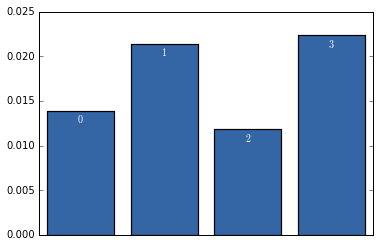

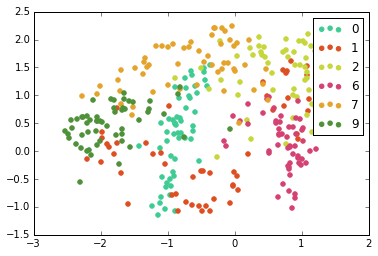

In [8]:
model.kern.plot_ARD()
plot_model(model, model.linear.variances.argsort()[-2:], labels.flatten())
plt.legend()

As you can see the solution with a linear kernel is the same as the PCA solution with the exception of rotational changes and axis flips.

For the sake of time, the solution you see was only running for 1000 iterations, thus it might not be converged fully yet. The GP-LVM proceeds by iterative optimization of the *inputs* to the covariance. As we saw in the lecture earlier, for the linear covariance, these latent points can be optimized with an eigenvalue problem, but generally, for non-linear covariance functions, we are obliged to use gradient based optimization.

### Exercise 1

How do your linear solutions differ between PCA and GPLVM with a linear kernel? Look at the plots and also try and consider how the linear ARD parameters compare to the eigenvalues of the principal components.

### Exercise 2 

The next step is to use a non-linear mapping between inputs $\mathbf{X}$ and ouputs $\mathbf{Y}$ by selecting the exponentiated quadratic (`GPy.kern.RBF`) covariance function. How does the nonlinear model differe from the linear model? Are there digits that the GPLVM with an exponentiated quadratic covariance can separate, which PCA is not able to? Try modifying the covariance function and running the model again. For example you could try a combination of the linear and exponentiated quadratic covariance function or the Matern 5/2. If you run into stability problems try initializing the covariance function parameters differently.

In [9]:
kern = GPy.kern.RBF(input_dim)

## Bayesian GPLVM

In GP-LVM we use a point estimate of the distribution of the input $\mathbf{X}$. This estimate is derived through maximum likelihood or through a maximum a posteriori (MAP) approach. Ideally, we would like to also estimate a distribution over the input $\mathbf{X}$. In the Bayesian GPLVM we approximate the true distribution $p(\mathbf{X}|\mathbf{Y})$ by a variational approximation $q(\mathbf{X})$ and integrate $\mathbf{X}$ out. 

Approximating the posterior in this way allows us to optimize a lower bound on the marginal likelihood. Handling the uncertainty in a principled way allows the model to make an assessment of whether a particular latent dimension is required, or the variation is better explained by noise. This allows the algorithm to switch off latent dimensions. The switching off can take some time though, so below in Section 6 we provide a pre-learnt module, but to complete section 6 you'll need to be working in the IPython console instead of the notebook.

For the moment we'll run a short experiment applying the Bayesian GP-LVM with an exponentiated quadratic covariance function.

In [10]:
# Model optimization
input_dim = 5 # How many latent dimensions to use
kern = GPy.kern.RBF(input_dim,ARD=True) # ARD kernel
model = GPy.models.BayesianGPLVM(Yn, input_dim=input_dim, kernel=kern, num_inducing=25)

# initialize noise as 1% of variance in data
model.Gaussian_noise.variance = model.Y.var()/100.

In [11]:
model.optimize(messages=True)

In [12]:
def plot_model(m, which_dims, labels):
    fig = plt.figure(); ax = fig.add_subplot(111)
    X = m.X[:,which_dims]
    ulabs = []
    for lab in labels:
        if not lab in ulabs:
            ulabs.append(lab)
            pass
        pass
    for i, lab in enumerate(ulabs):
        ax.scatter(*X.mean[labels==lab].T,marker='o',color=colors[i],label=lab)
        pass
    pass


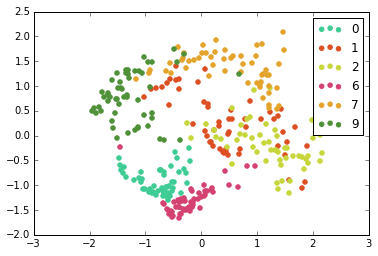

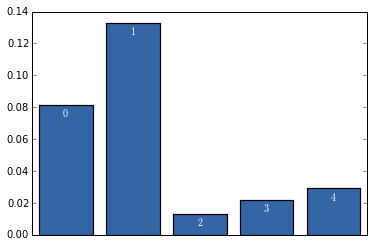

In [13]:
# Plotting the model
plot_model(model, model.rbf.lengthscale.argsort()[:2], labels.flatten())
plt.legend()
model.kern.plot_ARD()
# Saving the model:
model.pickle('bgplvm_rbf.pickle')

Because we are now also considering the uncertainty in the model, this optimization can take some time. However, you are free to interrupt the optimization at any point selecting `Kernel->Interupt` from the notepad menu. This will leave you with the model, `m` in the current state and you can plot and look into the model parameters. 

### Exercise 3

How does the Bayesian GP-LVM compare with the standard model?

### Preoptimized Model

A good way of working with latent variable models is to interact with the latent dimensions, generating data. This is a little bit tricky in the notebook, so below in section 6 we provide code for setting up an interactive demo in the standard IPython shell. If you are working on your own machine you can try this now. Otherwise continue with section 5.

## Multiview Learning: Manifold Relevance Determination

In Manifold Relevance Determination we try to find one latent space, common for $K$ observed output sets (modalities) $\{\mathbf{Y}_{k}\}_{k=1}^{K}$. Each modality is associated with a separate set of ARD parameters so that it switches off different parts of the whole latent space and, therefore, $\mathbf{X}$ is softly segmented into parts that are private to some, or shared for all modalities. Can you explain what happens in the following example?

Again, you can stop the optimizer at any point and explore the result obtained with the so far training:

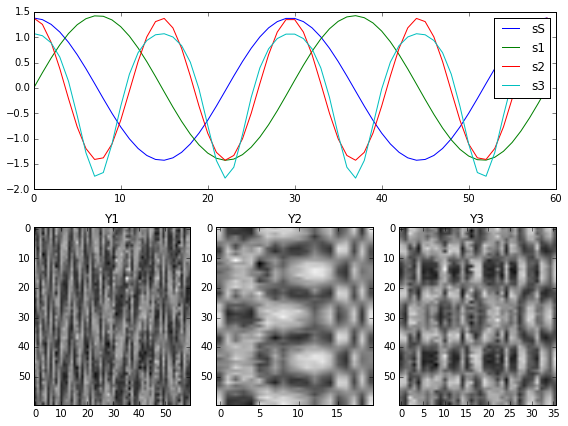

In [14]:
model = GPy.examples.dimensionality_reduction.mrd_simulation(optimize = False, plot=False)
model.optimize()

In [15]:
model.optimize(messages=True)

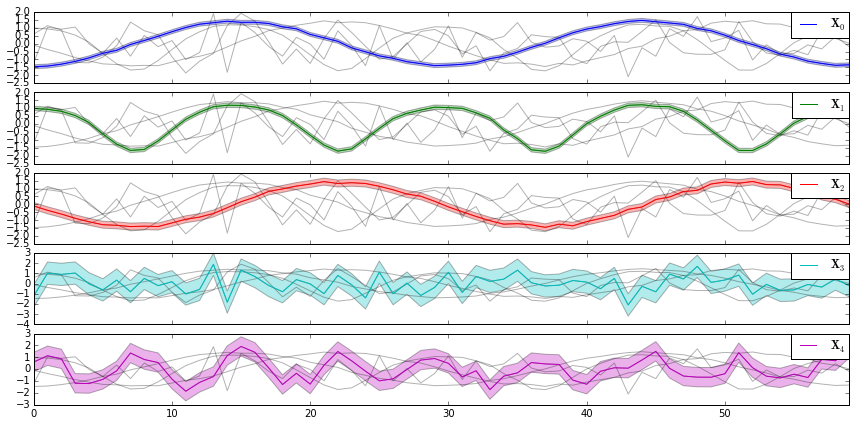

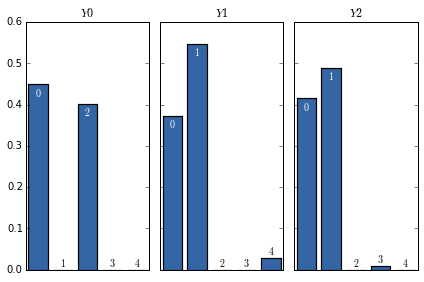

In [16]:
_ = model.X.plot()
model.plot_scales()

### Exercise 4

The simulated data set is a sinusoid and a double frequency sinusoid function as input signals.

Which signal is shared across the three datasets? Which are private? Are there signals shared only between two of the three datasets?

## Interactive Demo: For Use Outside the Notebook

The module below loads a pre-optimized Bayesian GPLVM model (like the one you just trained) and allows you to interact with the latent space. 
Three interactive figures pop up: the latent space, the ARD scales and a sample in the output space (corresponding to the current selected latent point of the other figure). 
You can sample with the mouse from the latent space and obtain samples in the output space. 
You can select different latent dimensions to vary by clicking on the corresponding scales with the left and right mouse buttons.
This will also cause the latent space to be projected on the selected latent dimensions in the other figure.

In [17]:
import urllib2, os, sys

model_path =  'digit_bgplvm_demo.pickle' # local name for model file
status = ""

re = 0
if len(sys.argv) == 2:
    re = 1

if re or not os.path.exists(model_path): # only download the model new, if it was not already
    url = 'http://staffwww.dcs.sheffield.ac.uk/people/M.Zwiessele/gpss/lab3/digit_bgplvm_demo.pickle'
    with open(model_path, 'wb') as f:
        u = urllib2.urlopen(url)
        meta = u.info()
        file_size = int(meta.getheaders("Content-Length")[0])
        print "Downloading: %s" % (model_path)

        file_size_dl = 0
        block_sz = 8192
        while True:
            buff = u.read(block_sz)
            if not buff:
                break
            file_size_dl += len(buff)
            f.write(buff)
            sys.stdout.write(" "*(len(status)) + "\r")
            status = r"{:7.3f}/{:.3f}MB [{: >7.2%}]".format(file_size_dl/(1.*1e6), file_size/(1.*1e6), float(file_size_dl)/file_size)
            sys.stdout.write(status)
            sys.stdout.flush()
        sys.stdout.write(" "*(len(status)) + "\r")
        print status
else:
    print "Already cached, to reload run with 'reload' as the only argument"

Downloading: digit_bgplvm_demo.pickle
  1.600/1.600MB [100.00%]


In [18]:
import cPickle as pickle
with open('./digit_bgplvm_demo.pickle', 'rb') as f:
    model = pickle.load(f)

Prepare for plotting of this model. If you run on a webserver the interactive plotting will not work. Thus, you can skip to the next codeblock and run it on your own machine, later.

In [ ]:
%matplotlib qt
fig = plt.figure('Latent Space & Scales', figsize=(16,6))
ax_latent = fig.add_subplot(121)
ax_scales = fig.add_subplot(122)

fig_out = plt.figure('Output', figsize=(1,1))
ax_image  = fig_out.add_subplot(111)
fig_out.tight_layout(pad=0)

data_show = GPy.plotting.matplot_dep.visualize.image_show(model.Y[0:1, :], dimensions=(16, 16), transpose=0, invert=0, scale=False, axes=ax_image)
lvm_visualizer = GPy.plotting.matplot_dep.visualize.lvm_dimselect(model.X.mean.copy(), model, data_show, ax_latent, ax_scales, labels=labels.flatten())

**Observations**

Confirm the following observations by interacting with the demo:

* We tend to obtain more "strange" outputs when sampling from latent space areas away from the training inputs.
* When sampling from the two dominant latent dimensions (the ones corresponding to large scales) we differentiate between all digits. Also note that projecting the latent space into the two dominant dimensions better separates the classes.
* When sampling from less dominant latent dimensions the outputs vary in a more subtle way.

You can also run the dimensionality reduction example

In [20]:
%matplotlib qt
GPy.examples.dimensionality_reduction.bgplvm_oil()

[[-0.90855305  0.17293507 -0.40334671  0.44832111  0.56233372  1.68589217
  -1.02459653]]
use left and right mouse buttons to select dimensions
Press enter to finish


bayesian_gplvm.,Value,Constraint,Prior,Tied to
latent space_1.mean,"(200, 7)",,,
latent space_1.variance,"(200, 7)",+ve,,
inducing inputs,"(40, 7)",,,
rbf.variance,2.38180099386,+ve,,
rbf.lengthscale,"(7,)",+ve,,
Gaussian_noise.variance,0.00089103583985,+ve,,


**Questions**

* Can you see a difference in the ARD parameters to the non Bayesian GPLVM?
* How does the Bayesian GPLVM allow the ARD parameters of the RBF kernel magnify the two first dimensions?
* Is Bayesian GPLVM better in differentiating between different kinds of digits?
* Why does the starting noise variance have to be lower then the variance of the observed values?
* How come we use the lowest variance when using a linear kernel, but the highest lengtscale when using an RBF kernel?

## References

C. M. Bishop. Pattern recognition and machine learning, volume 1. springer New York, 2006.

T. de Campos, B. R. Babu, and M. Varma. Character recognition in natural images. VISAPP 2009.

N. D. Lawrence. Probabilistic non-linear principal component analysis with Gaussian process latent variable models. In Journal of Machine Learning Research 6, pp 1783--1816, 2005